In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



C:\Users\xia\AppData\Local\Temp\ipykernel_8396\2869826499.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_8396\2869826499.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [5]:
def getData(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [6]:
def tmp(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [7]:
X,Y = getData("../data/dataBow1.csv","../data/dataSelection1.csv")
X=X.astype("int64")
X=np.unique(X,axis=0,return_index=True)
X,index = X
Y = Y[index]

In [8]:
print(np.unique(Y,return_counts = True))

(array(['CTRL + Left', 'CTRL + Right', 'CTRL + Shift + Left',
       'CTRL + Shift + Right', 'CTRL+ A (SelectAll)',
       'CopyPaste (CTRL + C -> CTRL + V)', 'Fin (End)', 'Home',
       'Search&Replace (CTRL + R)', 'Shift + End', 'Shift + Home',
       'WordDel (CTRL + Backspace)', 'WriteWord'], dtype=object), array([ 2257,  2266,  7345,  6271,  2312,  2469,  2142,  4257,  2921,
        2174,  2278,  2287, 23508], dtype=int64))


In [9]:

le = preprocessing.LabelEncoder()

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
#anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [10]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(X),torch.Tensor(Ynum).type(torch.LongTensor))

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_tanH_stack = nn.Sequential(
            nn.Linear(5772, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, len(np.unique(Y)))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanH_stack(x)
        return logits


In [49]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [50]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [51]:
epochs = 50

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=2000,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=2000,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 5.475491  [ 2000/49989]
Test Error: 
 Accuracy: 44.8%, Avg loss: 1.795384 

Epoch 2
-------------------------------
loss: 1.787307  [ 2000/49989]
Test Error: 
 Accuracy: 45.1%, Avg loss: 1.708433 

Epoch 3
-------------------------------
loss: 1.719857  [ 2000/49989]
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.717535 

Epoch 4
-------------------------------
loss: 1.700629  [ 2000/49989]
Test Error: 
 Accuracy: 50.6%, Avg loss: 1.643806 

Epoch 5
-------------------------------
loss: 1.594896  [ 2000/49989]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.433072 

Epoch 6
-------------------------------
loss: 1.395514  [ 2000/49989]
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.389017 

Epoch 7
-------------------------------
loss: 1.346031  [ 2000/49989]
Test Error: 
 Accuracy: 53.2%, Avg loss: 1.396119 

Epoch 8
-------------------------------
loss: 1.428141  [ 2000/49989]
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.402279 

Epoch 9
----------------

In [25]:
extraEp = 100

for t in range(extraEp):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.561133  [ 2000/49989]
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.594145 

Epoch 2
-------------------------------
loss: 1.596889  [ 2000/49989]
Test Error: 
 Accuracy: 47.1%, Avg loss: 1.588480 

Epoch 3
-------------------------------
loss: 1.562672  [ 2000/49989]
Test Error: 
 Accuracy: 47.0%, Avg loss: 1.584182 

Epoch 4
-------------------------------
loss: 1.568540  [ 2000/49989]
Test Error: 
 Accuracy: 47.1%, Avg loss: 1.577043 

Epoch 5
-------------------------------
loss: 1.577303  [ 2000/49989]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.574545 

Epoch 6
-------------------------------
loss: 1.540320  [ 2000/49989]
Test Error: 
 Accuracy: 49.2%, Avg loss: 1.563182 

Epoch 7
-------------------------------
loss: 1.551659  [ 2000/49989]
Test Error: 
 Accuracy: 51.2%, Avg loss: 1.543947 

Epoch 8
-------------------------------
loss: 1.551827  [ 2000/49989]
Test Error: 
 Accuracy: 51.6%, Avg loss: 1.555435 

Epoch 9
----------------

loss: 1.195693  [ 2000/49989]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.236696 

Epoch 69
-------------------------------
loss: 1.179720  [ 2000/49989]
Test Error: 
 Accuracy: 58.5%, Avg loss: 1.233981 

Epoch 70
-------------------------------
loss: 1.185599  [ 2000/49989]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.235449 

Epoch 71
-------------------------------
loss: 1.186076  [ 2000/49989]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.232083 

Epoch 72
-------------------------------
loss: 1.187459  [ 2000/49989]
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.226578 

Epoch 73
-------------------------------
loss: 1.199325  [ 2000/49989]
Test Error: 
 Accuracy: 58.9%, Avg loss: 1.232018 

Epoch 74
-------------------------------
loss: 1.189011  [ 2000/49989]
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.229933 

Epoch 75
-------------------------------
loss: 1.154321  [ 2000/49989]
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.267770 

Epoch 76
-------------------------------
loss: 1.247928  

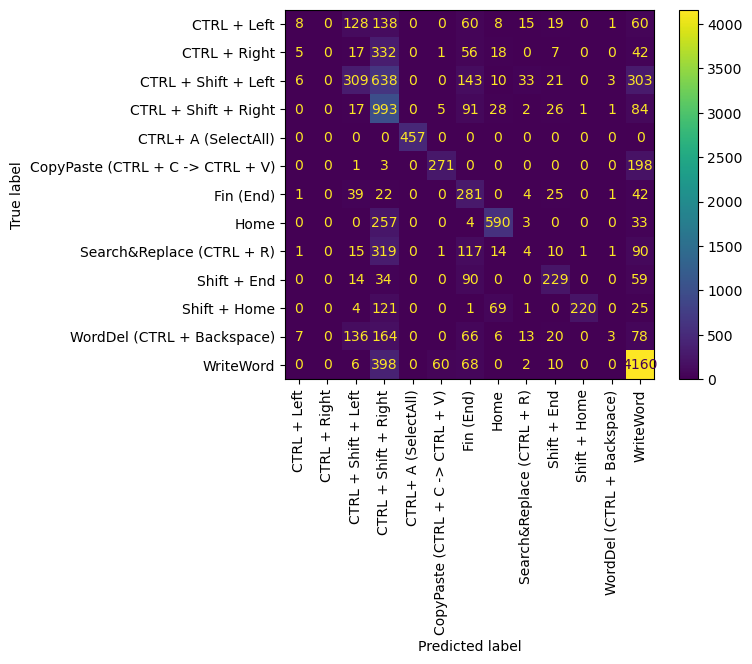

In [70]:


#Used to calculate the confusion matrix
y_true = []
y_pred = []
predictions = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    predictions.extend(pred.tolist())
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot()
plt.xticks(rotation=90)
plt.show()

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

In [76]:

prec = np.round(precision_score(y_true, y_pred, average=None), 3)
rap = np.round(recall_score(y_true, y_pred, average=None), 3)
FPR = FP/(FP+TN)
print("Precision :",dict(zip(le.classes_, prec)))
print("\n")
print("Rappel :", dict(zip(le.classes_, rap)))
print("\n")
#print("FPR : ",dict(zip(le.classes_, FP/conf_matrix.sum(axis=0))))
print("FPR : ",dict(zip(le.classes_, FPR)))
print("\n")
print("ROC AUC SCORE :",roc_auc_score(y_true, predictions, multi_class='ovr'))

Precision : {'CTRL + Left': 0.286, 'CTRL + Right': 0.0, 'CTRL + Shift + Left': 0.45, 'CTRL + Shift + Right': 0.29, 'CTRL+ A (SelectAll)': 1.0, 'CopyPaste (CTRL + C -> CTRL + V)': 0.802, 'Fin (End)': 0.288, 'Home': 0.794, 'Search&Replace (CTRL + R)': 0.052, 'Shift + End': 0.624, 'Shift + Home': 0.991, 'WordDel (CTRL + Backspace)': 0.3, 'WriteWord': 0.804}


Rappel : {'CTRL + Left': 0.018, 'CTRL + Right': 0.0, 'CTRL + Shift + Left': 0.211, 'CTRL + Shift + Right': 0.796, 'CTRL+ A (SelectAll)': 1.0, 'CopyPaste (CTRL + C -> CTRL + V)': 0.573, 'Fin (End)': 0.677, 'Home': 0.665, 'Search&Replace (CTRL + R)': 0.007, 'Shift + End': 0.538, 'Shift + Home': 0.499, 'WordDel (CTRL + Backspace)': 0.006, 'WriteWord': 0.884}


FPR :  {'CTRL + Left': 0.0016582372937567365, 'CTRL + Right': 0.0, 'CTRL + Shift + Left': 0.03417331399564902, 'CTRL + Shift + Right': 0.21564444444444444, 'CTRL+ A (SelectAll)': 0.0, 'CopyPaste (CTRL + C -> CTRL + V)': 0.005571725571725572, 'Fin (End)': 0.05760158900935198, 'Home

C:\Users\xia\AppData\Local\anaconda3\envs\STAGE\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
